In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read pool data from Google drive

In [137]:
files = glob.glob("/content/drive/MyDrive/Colab/nn-ppm-model/data/pools_ge250_loans_part*.csv.gz")
dfs = [pd.read_csv(f, sep=",") for f in files]

df = pd.concat(dfs,ignore_index=True)
del dfs

Add seasonality and jumbo indicator

In [138]:
df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))
df['jumbo_flag'] = df['aols'].apply(lambda x: 1 if x>500000 else 0)

In [139]:
df.groupby(['jumbo_flag']).size()

jumbo_flag
0    594533
dtype: int64

In [140]:
print(f"Min asofdate: {min(df['asofdate'])} max: {max(df['asofdate'])}")

Min asofdate: 201001 max: 202001


In [141]:
# list(df.columns)
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594533 entries, 0 to 594532
Data columns (total 112 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   poolno              594533 non-null  object 
 1   asofdate            594533 non-null  int64  
 2   cusip               594533 non-null  object 
 3   spread              594533 non-null  float64
 4   SMM                 594533 non-null  float64
 5   DayCount            594533 non-null  float64
 6   OBal                594533 non-null  float64
 7   CBal                594533 non-null  float64
 8   factor              594533 non-null  float64
 9   Coupon              594533 non-null  float64
 10  Wac                 594533 non-null  float64
 11  Wam                 594533 non-null  float64
 12  Age                 594533 non-null  float64
 13  aols                594533 non-null  float64
 14  waols               594533 non-null  float64
 15  ONLoans             594533 non-nu

In [142]:
print(f'df.shape: {df.shape}')

df.shape: (594533, 112)


Add seasonality dummies

In [143]:
dummies = pd.get_dummies(df['Seasonality'],drop_first=True)
df = df.drop('Seasonality',axis=1)
df = pd.concat([df,dummies],axis=1)

print(f'df.shape = {df.shape}')

df.shape = (594533, 122)


Define features (columns) are to be used in the model

In [144]:
model_columns = ['asofdate',
                 'SMM',
                 'jumbo_flag',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM'] + list(dummies.columns)

Pick pools5 with loan count >= 500 loans

In [145]:
cnloans = 500

dfm = df[df['cnloans'] >= cnloans][model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (286261, 114)


Split data between training and test

In [102]:
data_cutoff = 201801

dfm_train = dfm[dfm['asofdate'] <  data_cutoff]
# dfm_train = dfm
dfm_test  = dfm[dfm['asofdate'] >= data_cutoff]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}\n')

print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (199416, 112)
y_train.shape = (199416,)


X_test.shape  = (86845, 112)
y_test.shape  = (86845,)


First, let's scale train/test data because buiding a neural net

In [103]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Import TF Keras libraries

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout,BatchNormalization,Input
from tensorflow.keras.activations import relu
from tensorflow.keras.constraints import max_norm

# Define [feed forward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) model for mortgage prepayments

In [105]:
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='rmsprop', loss='mse')

### Train the model for 100 epochs

In [ ]:
model.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), batch_size=1024, epochs=100)

Optionally save the resulting model

In [136]:
# model.save("/content/drive/MyDrive/Colab/nn-ppm-model/30yr_fixed.h5")

Plot the loss function

Text(0, 0.5, 'Loss')

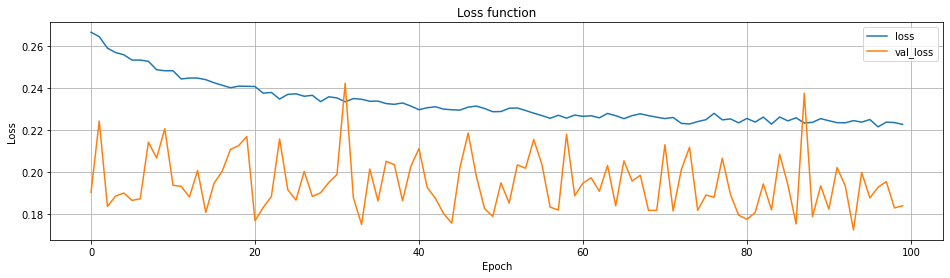

In [111]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)
plt.title("Loss function")
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Model Validation

In [112]:
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.3014
(test set) mean sq root sq error     = 0.429
(test set) explained variance score  = 0.6281


(train set) mean absolute error      = 0.2887
(train set) mean sq root sq error    = 0.3993
(train set) explained variance score = 0.8


Plot test actual vs. predictions

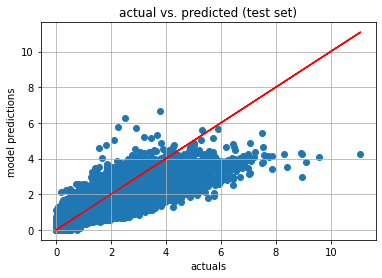

In [113]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

Plot train actual vs. predictions

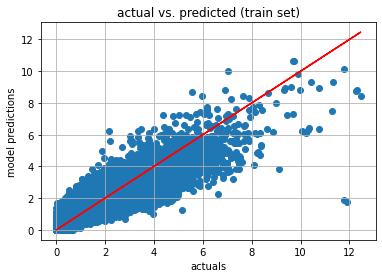

In [114]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

### Validation of a neural network model on large populations of pools/loans
Here we examine model performance on large populations of loans

In [115]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    fig = plt.figure(figsize=fsize)
    
    plt.axis('off')
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

Root-mean-square error (RMSE) by coupon

In [116]:
def rmse_by_coupon(dframe,lcoup=2.5,hcoup=5,col_name='RMSE (CPR)'):
    
    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    RMSE_by_coupon = dict()
    
    for i in range(int((hcoup-lcoup)*2 + 1)):
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            act_vs_pred = ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].dropna()
            RMSE_by_coupon[coupon] = np.sqrt(mean_squared_error(act_vs_pred[('CPR',coupon)],act_vs_pred[('model CPR'),coupon]))
            
    RMSE_by_coupon = pd.DataFrame({col_name:list(RMSE_by_coupon.values())},index=RMSE_by_coupon.keys())
    RMSE_by_coupon.index.name = 'Coupon'
    
    return RMSE_by_coupon

Predict from the model we have created

In [117]:
df['model SMM'] = model.predict(scaler.transform(df[model_columns].drop(['SMM','asofdate'],axis=1)))

In [118]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

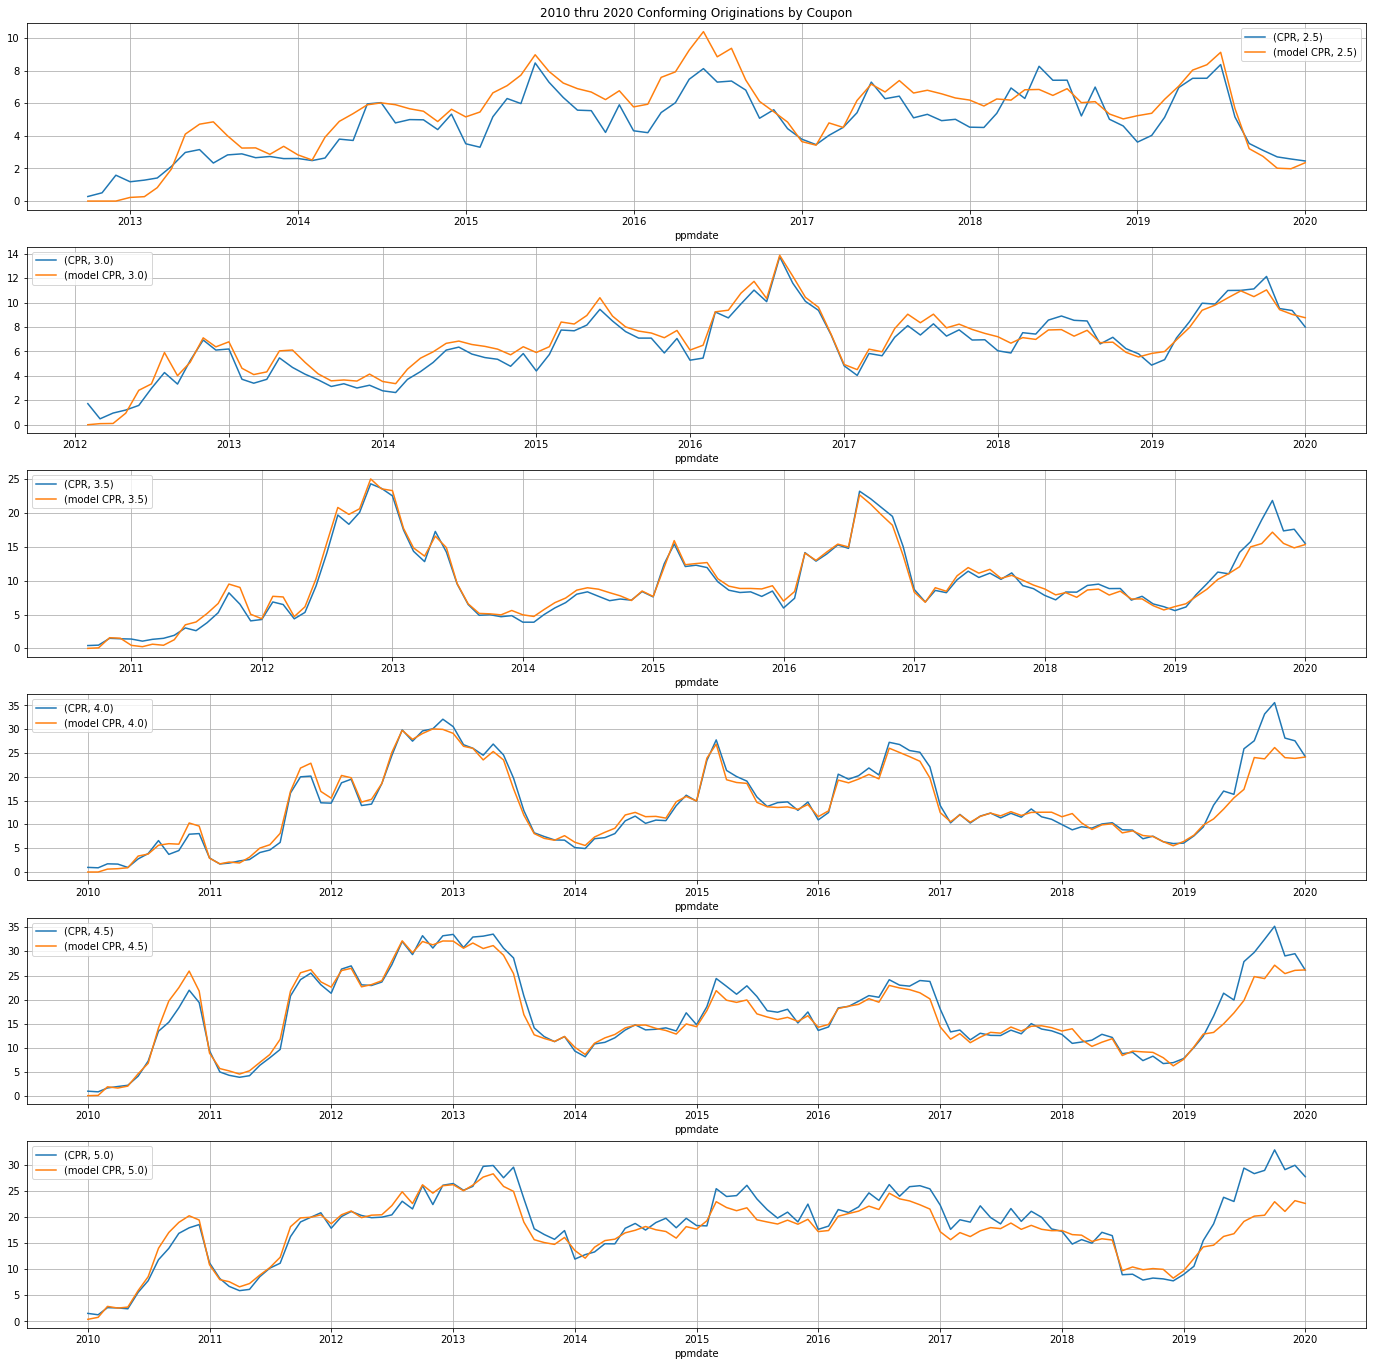

In [119]:
valReport(df[df['cnloans']>=cnloans],graphTitle='2010 thru 2020 Conforming Originations by Coupon',fsize=(24,24))

In [120]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']<data_cutoff)],col_name='2010 - 2020 Vintages NN RMSE (CPR)'),2)

,2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,1.19
3.0,0.76
3.5,0.78
4.0,1.09
4.5,1.53
5.0,1.92


In [121]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff)],col_name='2010 - 2020 Vintages NN RMSE (CPR)'),2)

,2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,0.89
3.0,0.68
3.5,1.52
4.0,3.66
4.5,3.61
5.0,4.97


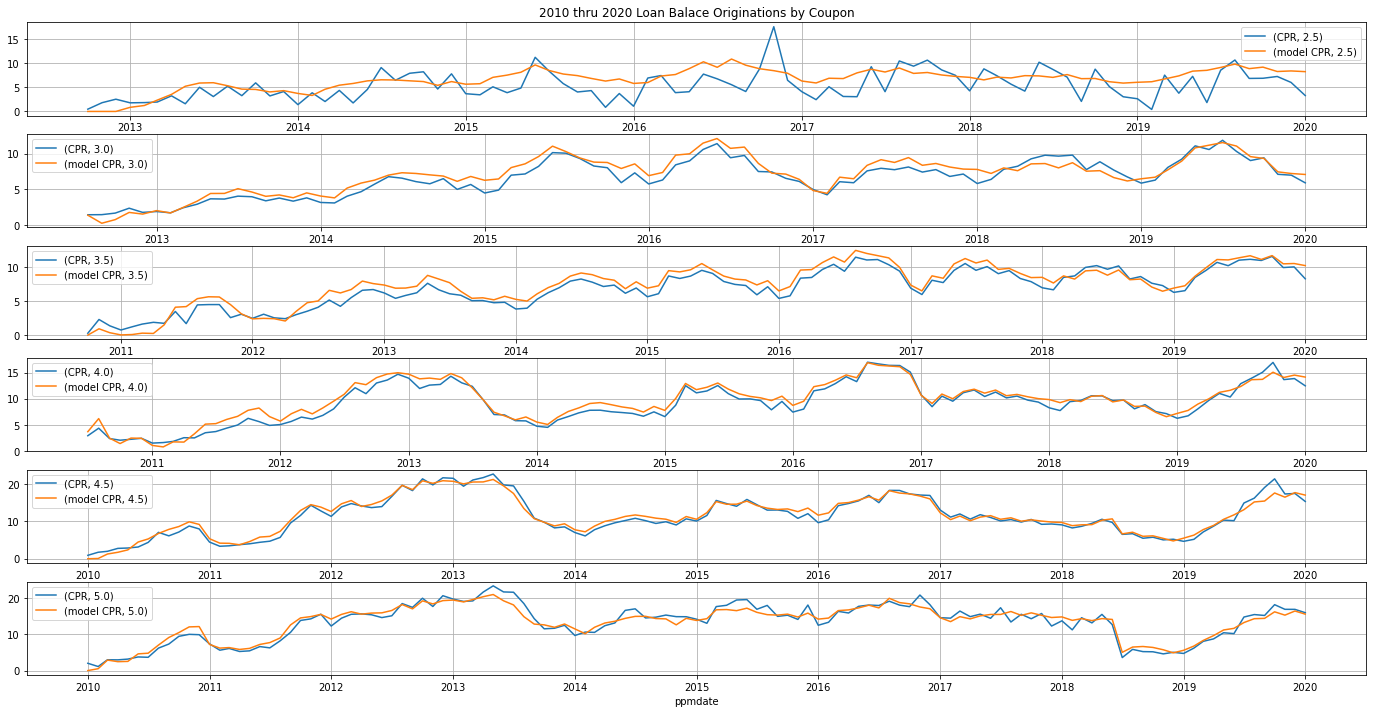

In [128]:
valReport(df[(df['cnloans']>=cnloans) & (df['waols'] <= 200000)],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))